In [1]:
import networkx as nx
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from util import constants
from util.config_util import get_model_params, get_task_params, get_train_params
from tf2_models.trainer import Trainer
from absl import app
from absl import flags

from util.models import MODELS
from util.tasks import TASKS

%matplotlib inline
import pandas as pd
import seaborn as sns; sns.set()

from attention_graph_util import *

In [2]:
from tf2_models.lm_transformer import ClassifierBERT

chkpt_dir='../tf_ckpts'

task_name = 'word_sv_agreement_vp'
task = TASKS[task_name](get_task_params(), data_dir='../data')

Vocab len:  10034


In [3]:
model_name = 'cl_gpt2'
model_config = 'big_gpt_v5'

cl_token = task.databuilder.sentence_encoder().encode(constants.bos)
hparams=get_model_params(task, model_name, model_config)
hparams.output_attentions = True
hparams.output_embeddings = True
hparams.output_hidden_states = True
model_1 = ClassifierBERT(hparams=hparams, cl_token=cl_token)

model config: big_gpt_v5
{'embedding_dim': 256, 'resid_pdrop': 0.2, 'embd_pdrop': 0.2, 'attn_pdrop': 0.3, 'initializer_range': 0.05}


In [4]:
x, y = iter(task.valid_dataset).next()

index = 30
sentence =  task.databuilder.sentence_encoder().decode(x[index])#'<bos> the young girl who plays with the older kids is happy <eos>'
print(sentence)
#'<bos> the boys who play football with the old man <eos>'
encoded_sentence = task.databuilder.sentence_encoder().encode(sentence)
logits, extra = model_1.detailed_call(np.asarray([encoded_sentence]))
print((np.argmax(logits) == y[index]).numpy())
logits, last_state, presents, attentions, embeddings = extra
_attentions = [att.numpy() for att in attentions]
attentions_mat = np.asarray(_attentions)[:,0]
print(attentions_mat.shape)

<bos> according to contemporary accounts in the NNP NNPS the college of cardinals was divided into NNS of charles NN ( VBZ NNP ) and the imperial party ( VBZ NNP ) , but the exact reconstruction of these parties <eos>
False
(6, 8, 41, 41)


6


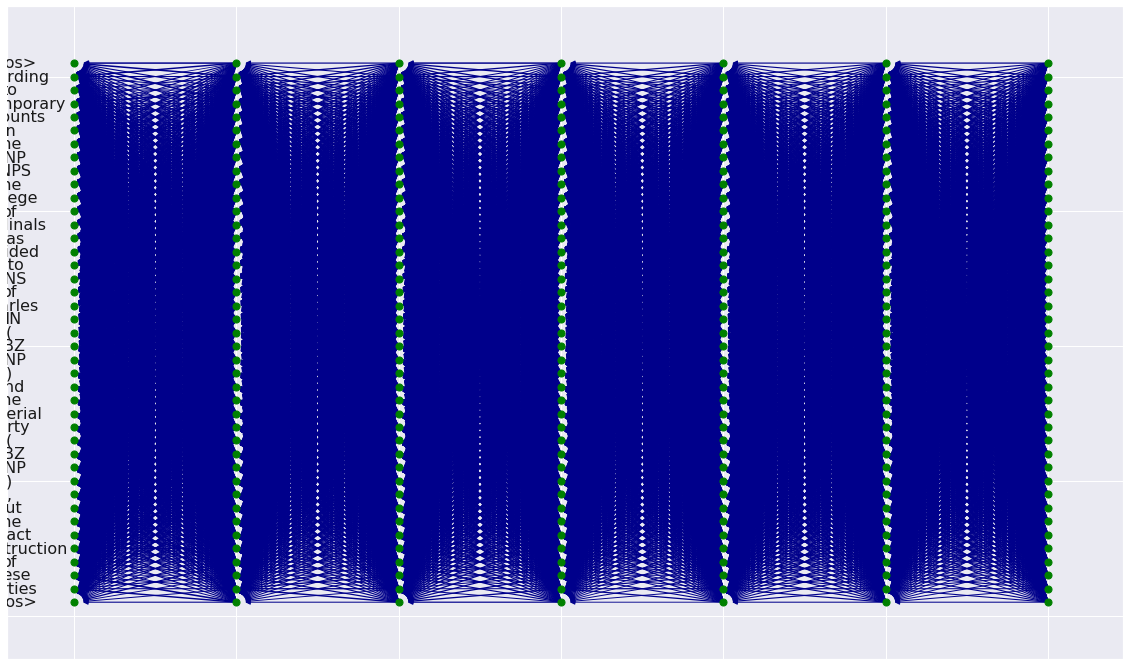

In [5]:
att_mat = attentions_mat.sum(axis=1)
adj_mat, labels_to_index = get_adjmat(mat=att_mat, input_tokens=sentence.split())

G = draw_attention_graph(adj_mat,labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])